## Setup

In [1]:

import pickle
import gzip
import unet
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchvision.ops import sigmoid_focal_loss
from sklearn.preprocessing import StandardScaler

/home/lamberto/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
import random
import numpy as np
import torch

SEED = 42

# Python
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Make CUDA deterministic (slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [5]:
train_data = load_zipped_pickle('train.pkl')

## Extracting labeled frames

The main idea here is to augment the labeled samples (frames) we already have (3 per video, 195 in total).

As reported by Ronnenberger et al., a score of 0.92 (IOU), on a cell segmentation task, was attained by training the model only on 30 samples. 

We extract only the labeled frame to attempt training a UNet uniquely on those, as Ronnenberget et al. report a high score (on a cell segmentation task) with a training set of only 30 images.

In [6]:
labeled_train_data = []

for sample in train_data:
    for i in sample['frames']:
        labeled_train_data.append({
            'name': sample['name'],
            'frame': sample['video'][:, :, i],          # take labeled frame
            'label': sample['label'][:, :, i],
            'dataset': sample['dataset'],
            'box' : sample['box']
        })

print('Total labeled frames used for training', len(labeled_train_data))

Total labeled frames used for training 195


## Define UNet architecture

After getting the available labeled frames, we use simple UNet demo model (https://github.com/ptrblck/pytorch_misc/blob/master/unet_demo.py) to assess performance given such data.

In [7]:
"""
Simple UNet demo

@author: ptrblck
"""

class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(BaseConv, self).__init__()
        
        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x
    
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DownConv, self).__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x
    
class UpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels, kernel_size, stride, padding):
        super(UpConv, self).__init__()

        self.conv_trans1 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2, padding=0)
        self.conv_block = BaseConv(
            in_channels=in_channels + in_channels_skip,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding)

    def forward(self, x, x_skip):

        x = self.conv_trans1(x)

        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x

# NOTE: ptrblck implementation has padding and
#       stride arguments swapped!
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_class, kernel_size, stride, padding, apply_sigmoid=True):
        super(UNet, self).__init__()
        self.n_class = n_class
        self.apply_sigmoid = apply_sigmoid

        self.init_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = DownConv(out_channels, 2 * out_channels, kernel_size, stride, padding)
        
        self.down2 = DownConv(2 * out_channels, 4 * out_channels, kernel_size, stride, padding)

        self.down3 = DownConv(4 * out_channels, 8 * out_channels, kernel_size, stride, padding)

        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels, kernel_size, stride, padding)

        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels, kernel_size, stride, padding)

        self.up1 = UpConv(2 * out_channels, out_channels, out_channels, kernel_size, stride, padding)

        self.out = nn.Conv2d(out_channels, n_class, kernel_size, stride, padding)
        
    def forward(self, x):
        # Encoder
        x = self.init_conv(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        # Decoder
        x_up = self.up3(x3, x2)
        x_up = self.up2(x_up, x1)
        x_up = self.up1(x_up, x)

        x_out = self.out(x_up)

        if self.n_class > 1:
            # NOTE: softmax for multi-object segmentation
            x_out = F.log_softmax(x_out, 1)
        else:
            # NOTE: for binary segmentation (background and
            #       object) we use sigmoid activation
            x_out = torch.sigmoid(x_out) if self.apply_sigmoid else x_out

        return x_out

## _IMPLEMENT BATCHING AND A GENERALIZING MODEL__

In [34]:
import cv2
def apply_bilateral(img,sigmaColor,sigmaSpace,n):
    img_copy = img.copy()
    for i in range(n):
        img_copy = cv2.bilateralFilter(img_copy,d=5,sigmaColor=sigmaColor,sigmaSpace=sigmaSpace)
    return img_copy 

## HIST

In [ ]:
def compute_histogram_equalization(v_channel):
    v_channel = np.array(v_channel)  
    hist = np.zeros(256)
    total_pixels = v_channel.size  
    for pixel in v_channel.flatten():  
        hist[int(pixel)] += 1
    return hist / total_pixels

def compute_comulative_distribution_equalization(hist):
    cdf = [0] * len(hist)  
    cdf[0] = hist[0]  
    for i in range(1, len(hist)):
        cdf[i] = cdf[i - 1] + hist[i]  
    return cdf

def normalize_cdf(cdf):
    cdf_min = min(cdf)
    cdf_max = max(cdf)
    if cdf_max == cdf_min:
        return [0] * len(cdf)  
    return [int((val - cdf_min) * 255 / (cdf_max - cdf_min)) for val in cdf]


def global_histogram_equalization(h, s, v):    

    hist = compute_histogram_equalization(v) 
    cdf = compute_comulative_distribution_equalization(hist)   
    cdf = normalize_cdf(cdf)

    v_equalized = np.zeros_like(v, dtype=np.uint8)
    height, width = v.shape
    for i in range(height):
        for j in range(width):
            v_equalized[i, j] = cdf[v[i, j]]
    
    return v_equalized 


In [9]:
import torch
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, map_coordinates

def elastic_deformation(image, mask, alpha=34, sigma=4):
    img_np = image.numpy() 
    mask_np = mask.numpy() 

    # NOTE: H, W
    shape = img_np.shape  

    # Random displacement fields
    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha

    # Meshgrid for coordinates
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = (y + dy).reshape(-1), (x + dx).reshape(-1)

    # NOTE: Apply deformation to frame
    deformed_img = map_coordinates(img_np, indices, order=1, mode='reflect').reshape(shape)

    # NOTE: Mask -- nearest neighbor to preserve labels
    deformed_mask = map_coordinates(mask_np, indices, order=0, mode='reflect').reshape(shape)

    # Convert back to torch tensors
    deformed_img = torch.from_numpy(deformed_img)
    deformed_mask = torch.from_numpy(deformed_mask)

    return deformed_img, deformed_mask


## MODEL

In [136]:
import torch 
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


class MitralDataset(Dataset):
    def __init__(self, samples, augment=False, target_size=(256,256)):
        self.samples = samples
        self.augment = augment
        self.target_size = target_size
    
    def __len__(self):
        return len(self.samples) * (2 if self.augment else 1)
    
    def __getitem__(self, idx):
        base_idx = idx % len(self.samples)
        view_id  = idx // len(self.samples)  # 0 = original, 1 = augmented

        item = self.samples[base_idx]

        frame_curr = item['frame'].copy()

        if np.max(frame_curr) > 1:
            frame = frame_curr / 255

            new = (frame < 0.4) & (frame > 0.15)
            frame[new] = np.minimum(1.0, frame[new] + 0.25)

            new_new = (frame >= 0.6)
            frame[new_new] = np.minimum(1.0, frame[new_new] + 0.3)

        frame = torch.tensor(frame).float()
        mask  = torch.tensor(item['label']).float()

        # plt.imshow(frame.numpy(), cmap='gray')

        # LARGE sigmaColor means only close neighbours are affecting the enhancing of the brightness, preserves fine details
        # sigmaColor = 10
        # # # SMAL sigmaSpace means only very close pixel matters, produces strong smoothing 
        # sigmaSpace = 0.13
        # iter = 100

        # print(frame.shape)
        # print('before', type(frame), frame.shape)
        # img = frame.numpy().astype(np.uint8)
        # equalized = global_histogram_equalization(None, None, img)
        # bilated = apply_bilateral(img,sigmaColor,sigmaSpace,iter)
        # new_frame = cv2.fastNlMeansDenoising(img, h=10, templateWindowSize=3, searchWindowSize=11)

        # plt.figure(figsize=(12,4))

        # plt.subplot(1,2,1)
        # plt.imshow(frame_curr, cmap='gray')
        # plt.title('Original frame')

        # plt.subplot(1,2,2)
        # plt.imshow(frame.numpy(), cmap='gray')
        # plt.title("Enhanced image")

        # plt.subplot(1,3,3)
        # plt.imshow(new_frame, cmap='gray')
        # plt.title("bilated image")

        # plt.subplot(1,4,4)
        # plt.imshow(frame.numpy(), cmap='gray')
        # plt.title("NEW image")

        # plt.show()

        # NOTE: this is a torch [H,W]
        # frame = torch.Tensor(equalized)

        if self.augment and view_id == 1:
            if random.random() > 0.5:
                frame = torch.flip(frame, dims=[-1])
                mask  = torch.flip(mask, dims=[-1])
            if random.random() > 0.5:
                frame = torch.flip(frame, dims=[-2])
                mask  = torch.flip(mask, dims=[-2])
            if random.random() > 0.5:
                frame, mask = elastic_deformation(frame, mask, alpha=34, sigma=4)
                
        # print('after', type(frame), frame.shape)

        # Resize with padding to preserve aspect ratio
        frame, mask = self.resize_and_pad(frame, mask, self.target_size)
        frame = (frame - frame.mean()) / (frame.std() + 1e-6)

        return frame, mask
    
    def resize_and_pad(self, frame, mask, target_size):
        c, h, w = 1, frame.shape[-2], frame.shape[-1]  # assuming frame shape is [H, W]
        scale = min(target_size[0]/h, target_size[1]/w)
        new_h, new_w = int(h*scale), int(w*scale)

        # print(type(frame), frame.shape)
        frame_resized = F.interpolate(frame.unsqueeze(0).unsqueeze(0), size=(new_h, new_w), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        mask_resized  = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(new_h, new_w), mode='nearest').squeeze(0).squeeze(0)
        # print(frame_resized.shape)

        pad_h = target_size[0] - new_h
        pad_w = target_size[1] - new_w
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        frame_padded = F.pad(frame_resized, (pad_left, pad_right, pad_top, pad_bottom))
        mask_padded  = F.pad(mask_resized,  (pad_left, pad_right, pad_top, pad_bottom))


        return frame_padded.unsqueeze(0), mask_padded.unsqueeze(0)

In [137]:
train_dataset = MitralDataset(labeled_train_data)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

Epoch 0: loss=0.0039
Epoch 1: loss=0.0038
Epoch 2: loss=0.0027
Epoch 3: loss=0.0023
Epoch 4: loss=0.0019
Epoch 5: loss=0.0016
Epoch 6: loss=0.0015
Epoch 7: loss=0.0016
Epoch 8: loss=0.0014
Epoch 9: loss=0.0012
Epoch 10: loss=0.0012
Epoch 11: loss=0.0015
Epoch 12: loss=0.0022
Epoch 13: loss=0.0015
Epoch 14: loss=0.0014
Epoch 15: loss=0.0011
Epoch 16: loss=0.0013
Epoch 17: loss=0.0013
Epoch 18: loss=0.0014
Epoch 19: loss=0.0016
Epoch 20: loss=0.0016
Epoch 21: loss=0.0010
Epoch 22: loss=0.0009
Epoch 23: loss=0.0012
Epoch 24: loss=0.0011
Epoch 25: loss=0.0009
Epoch 26: loss=0.0009
Epoch 27: loss=0.0011
Epoch 28: loss=0.0009
Epoch 29: loss=0.0010
Epoch 30: loss=0.0010
Epoch 31: loss=0.0009
Epoch 32: loss=0.0005
Epoch 33: loss=0.0011
Epoch 34: loss=0.0010
Epoch 35: loss=0.0009
Epoch 36: loss=0.0008
Epoch 37: loss=0.0008
Epoch 38: loss=0.0008
Epoch 39: loss=0.0010
Epoch 40: loss=0.0007
Epoch 41: loss=0.0009
Epoch 42: loss=0.0010
Epoch 43: loss=0.0016
Epoch 44: loss=0.0008
Epoch 45: loss=0.001

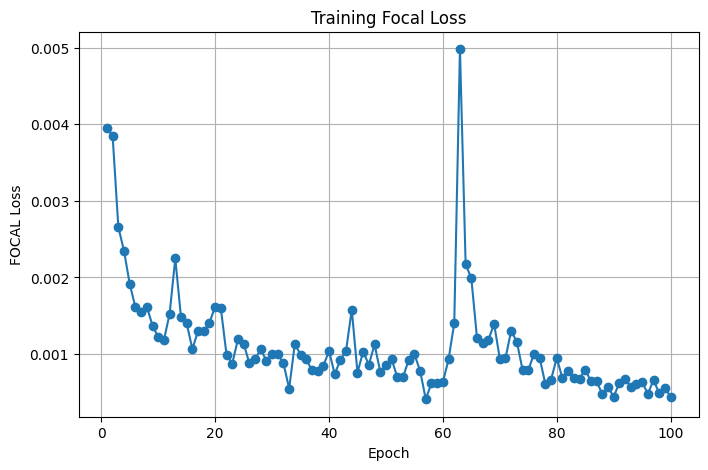

In [138]:
model = UNet(in_channels=1,
            out_channels=32,
            n_class=1,
            kernel_size=5,
            stride=1,
            padding=2,
            apply_sigmoid=False)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
epoch_losses = []
model = model.cuda()


for epoch in range(epochs):
    for frame,mask in train_loader:
        frame = frame.cuda()
        mask = mask.cuda()    
        optimizer.zero_grad()
        out = model(frame)
        loss = sigmoid_focal_loss(out,mask, reduction='mean')
        loss.backward()
        optimizer.step()
    
    epoch_losses.append(loss.item())
    print(f"Epoch {epoch}: loss={loss.item():.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("FOCAL Loss")
plt.title("Training Focal Loss")
plt.grid(True)
plt.show()


## loss

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, dims=(0,2,3)):  # sum over B,H,W (keep channel)
        super().__init__()
        self.smooth = smooth
        self.dims = dims

    def forward(self, probs, targets):
        probs = probs.float()
        targets = targets.float()
        intersection = torch.sum(probs * targets, dim=self.dims)
        union = torch.sum(probs, dim=self.dims) + torch.sum(targets, dim=self.dims)
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1.0 - dice.mean()

class SigmoidFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        targets = targets.float()
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        # pt = p if y=1 else (1-p); equivalently exp(-bce) for sigmoid BCE
        pt = torch.exp(-bce)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        loss = alpha_t * (1 - pt).pow(self.gamma) * bce
        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss
        # This “exp(-bce)” form is a standard stable implementation pattern. [web:67]

class DicePlusFocal(nn.Module):
    def __init__(self, dice_weight=0.5, dice_smooth=1.0, focal_alpha=0.25, focal_gamma=2.0):
        super().__init__()
        self.dice_weight = dice_weight
        self.dice = DiceLoss(smooth=dice_smooth)
        self.focal = SigmoidFocalLoss(alpha=focal_alpha, gamma=focal_gamma)

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        return self.dice_weight * self.dice(probs, targets) + (1 - self.dice_weight) * self.focal(logits, targets)
    
criterion = DicePlusFocal(dice_weight=0.5, dice_smooth=1.0, focal_alpha=0.25, focal_gamma=2.0)


## __SINGLE FRAME SEGMENTED__

In [147]:
torch.save(model, 'unet_17.pt')

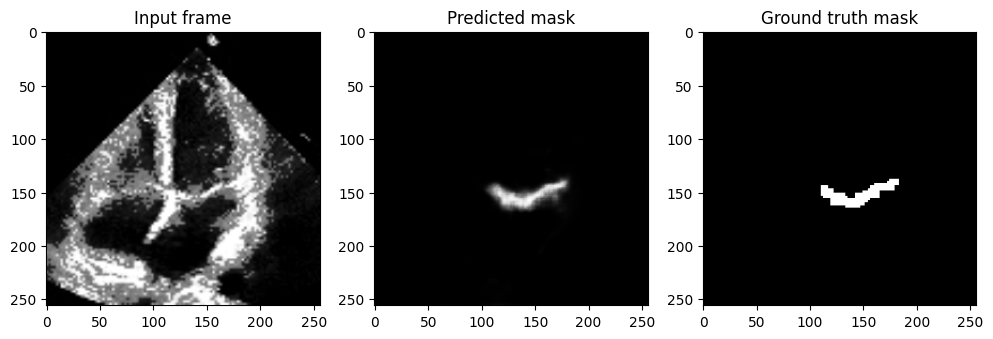

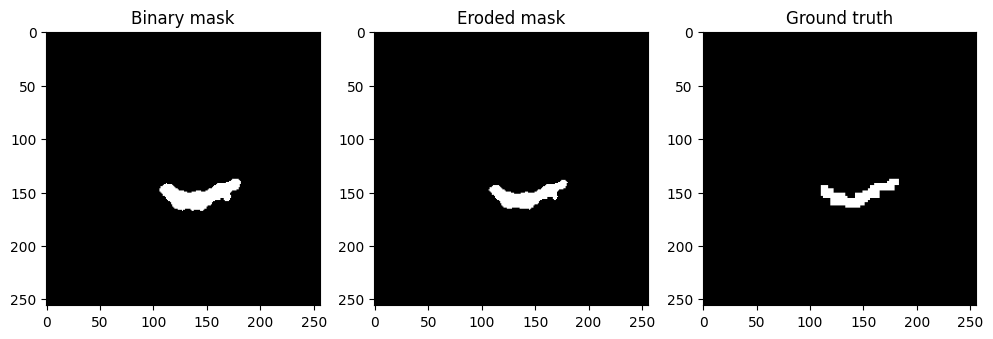

In [140]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()

frame, mask = train_dataset[70]     # frame: (1, H, W)
frame_in = frame.cuda().unsqueeze(0)      # (1, 1, H, W)

with torch.no_grad():

    pred = model(frame_in)         
    pred = torch.sigmoid(pred)     
    pred = pred.squeeze().cpu()    

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(frame.squeeze(), cmap='gray')
plt.title("Input frame")

plt.subplot(1,3,2)
plt.imshow(pred, cmap='gray')
plt.title("Predicted mask")

plt.subplot(1,3,3)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title("Ground truth mask")

plt.show()

def threshold_mask(pred, threshold):
    pred = pred.squeeze().detach().cpu()
    binary_mask = (pred > threshold).float()

    return binary_mask

with torch.no_grad():
    pred = model(frame_in)
    pred = torch.sigmoid(pred)
    pred = pred.squeeze()  

binary_mask = threshold_mask(pred, threshold=0.2)

def erode_mask(binary_mask, kernel_size=3, iterations=1):
    """
    binary_mask: (H, W) or (1, H, W) torch tensor with values {0,1}
    """
    if binary_mask.dim() == 2:
        binary_mask = binary_mask.unsqueeze(0).unsqueeze(0)
    elif binary_mask.dim() == 3:
        binary_mask = binary_mask.unsqueeze(0)

    x = binary_mask
    for _ in range(iterations):
        # erosion = min filter → max pool on inverted mask
        x = 1 - F.max_pool2d(
            1 - x,
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size // 2
        )

    return x.squeeze()

eroded_mask = erode_mask(
    binary_mask,
    kernel_size=3,   
    iterations=1     
)
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary mask")

plt.subplot(1,3,2)
plt.imshow(eroded_mask, cmap='gray')
plt.title("Eroded mask")

plt.subplot(1,3,3)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title("Ground truth")

plt.show()


# __EVALUATION METRICS__

In [142]:
import torch.nn.functional as F

def threshold_mask(pred, threshold=0.3):
    pred = pred.squeeze().detach().cpu()
    return (pred > threshold).float()

def erode_mask(binary_mask, kernel_size=3, iterations=1):
    if binary_mask.dim() == 2:
        binary_mask = binary_mask.unsqueeze(0).unsqueeze(0)
    elif binary_mask.dim() == 3:
        binary_mask = binary_mask.unsqueeze(0)

    x = binary_mask
    for _ in range(iterations):
        # erosion = min filter → max pool on inverted mask
        x = 1 - F.max_pool2d(
            1 - x,
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size // 2
        )

    return x.squeeze()

def dilate_mask(binary_mask, kernel_size=3, iterations=1):
    if binary_mask.dim() == 2:
        binary_mask = binary_mask.unsqueeze(0).unsqueeze(0)
    elif binary_mask.dim() == 3:
        binary_mask = binary_mask.unsqueeze(0)

    x = binary_mask
    for _ in range(iterations):
        # dilation = max filter → normal max pool
        x = F.max_pool2d(
            x,
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size // 2
        )

    return x.squeeze()


def compute_iou(pred, true):
    """
    pred, true: binary masks with values in {0,1}, shape (H, W)
    """
    pred = pred.bool()
    true = true.bool()
    
    intersection = (pred & true).sum().item()
    union = (pred | true).sum().item()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0 

    return intersection / union


def compute_dice(pred, true):
    pred = pred.bool()
    true = true.bool()

    intersection = (pred & true).sum().item()
    total = pred.sum().item() + true.sum().item()

    if total == 0:
        return 1.0 if intersection == 0 else 0.0

    return 2 * intersection / total


def evaluate_model(model, dataloader, threshold=0.25):
    model.eval()

    results = []
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for frames, masks in dataloader:
            frames = frames.cuda()
            masks= masks.cuda()

            logits = model(frames)
            probs  = torch.sigmoid(logits)

            for f, m, p in zip(frames, masks, probs):
                binary = threshold_mask(p, threshold)
                eroded = erode_mask(binary,kernel_size=3,iterations=1)
                dialated = dilate_mask(eroded, kernel_size=3, iterations=3) 

                true_mask = (m.squeeze().cpu() > 0.5).float()

                iou  = compute_iou(binary, true_mask)
                dice = compute_dice(binary, true_mask)

                iou_scores.append(iou)
                dice_scores.append(dice)

                results.append({
                    "frame": f.cpu(),
                    "mask": true_mask,
                    "pred_prob": p.squeeze().cpu(),
                    "binary": binary,
                    "eroded": eroded,
                    "dialated" : dialated,
                    "iou": iou,
                    "dice": dice
                })

    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)

    return results, avg_iou, avg_dice


In [143]:
results, avg_iou, avg_dice = evaluate_model(model, train_loader, threshold=0.2)

print("Average IoU:", avg_iou)
print("Average Dice:", avg_dice)


Average IoU: 0.6536771305423444
Average Dice: 0.7889092814095726


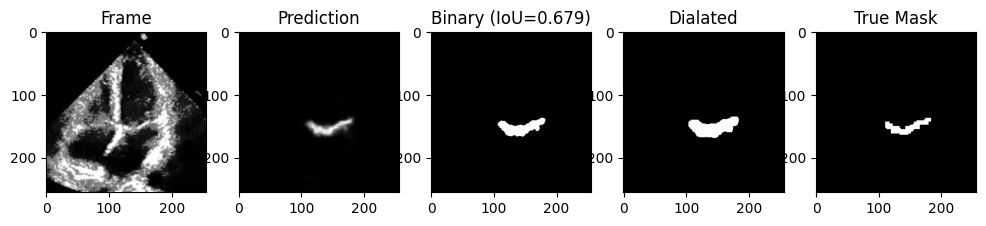

In [146]:
import matplotlib.pyplot as plt

sample = results[170]

plt.figure(figsize=(12,4))
plt.subplot(1,5,1); plt.imshow(sample["frame"].squeeze(), cmap='gray'); plt.title("Frame")
plt.subplot(1,5,2); plt.imshow(sample["pred_prob"], cmap='gray'); plt.title("Prediction")
plt.subplot(1,5,3); plt.imshow(sample["binary"], cmap='gray'); plt.title(f"Binary (IoU={sample['iou']:.3f})")
plt.subplot(1,5,4); plt.imshow(sample["eroded"], cmap='gray'); plt.title("Eroded")
plt.subplot(1,5,4); plt.imshow(sample["dialated"], cmap='gray'); plt.title("Dialated")
plt.subplot(1,5,5); plt.imshow(sample["mask"], cmap='gray'); plt.title("True Mask")
plt.show()


# __REAL TESTING__

In [50]:
test_data = load_zipped_pickle("test.pkl")

In [148]:
model = torch.load('unet_17.pt', weights_only=False)
model.eval()

UNet(
  (init_conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (down1): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): BaseConv(
      (act): ReLU()
      (conv1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (down2): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): BaseConv(
      (act): ReLU()
      (conv1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (down3): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): BaseConv(
      (act): ReLU()
      (conv1): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2)

## __REAL SUBMISSION__

In [149]:
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import imageio

THRESHOLD = 0.2
TARGET_SIZE = (256, 256)

def erode_mask(binary_mask, kernel_size=3, iterations=1):
    if binary_mask.dim() == 2:
        binary_mask = binary_mask.unsqueeze(0).unsqueeze(0)
    elif binary_mask.dim() == 3:
        binary_mask = binary_mask.unsqueeze(0)

    x = binary_mask
    for _ in range(iterations):
        # erosion = min filter → max pool on inverted mask
        x = 1 - F.max_pool2d(
            1 - x,
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size // 2
        )

    return x.squeeze()

def dilate_mask(binary_mask, kernel_size=3, iterations=1):
    if binary_mask.dim() == 2:
        binary_mask = binary_mask.unsqueeze(0).unsqueeze(0)
    elif binary_mask.dim() == 3:
        binary_mask = binary_mask.unsqueeze(0)

    x = binary_mask
    for _ in range(iterations):
        # dilation = max filter → normal max pool
        x = F.max_pool2d(
            x,
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size // 2
        )

    return x.squeeze()


def overlay_mask(frame, mask, alpha=0.4):
    """
    frame: (H, W) numpy
    mask:  (H, W) numpy (0/1)
    """
    frame_norm = (frame - frame.min()) / (frame.max() - frame.min() + 1e-6)
    frame_rgb = np.stack([frame_norm]*3, axis=-1)

    overlay = frame_rgb.copy()
    overlay[..., 0] = np.maximum(overlay[..., 0], mask)  

    blended = (1 - alpha) * frame_rgb + alpha * overlay
    return (blended * 255).astype(np.uint8)

os.makedirs("gifs_th02_last", exist_ok=True)

def resize_and_pad(frame, target_size):
    h, w = frame.shape
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)

    frame_resized = F.interpolate(
        frame.unsqueeze(0).unsqueeze(0),
        size=(new_h, new_w),
        mode="bilinear",
        align_corners=False
    ).squeeze()

    pad_h = target_size[0] - new_h
    pad_w = target_size[1] - new_w
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    frame_padded = F.pad(frame_resized, (pad_left, pad_right, pad_top, pad_bottom))

    meta = {
        "orig_size": (h, w),
        "pad": (pad_top, pad_bottom, pad_left, pad_right)
    }
    return frame_padded, meta

def unpad_and_restore(mask, meta):
    pt, pb, pl, pr = meta["pad"]
    h, w = meta["orig_size"]

    unpadded = mask[pt:mask.shape[0]-pb, pl:mask.shape[1]-pr]

    restored = F.interpolate(
        unpadded.unsqueeze(0).unsqueeze(0),
        size=(h, w),
        mode="nearest"
    ).squeeze()

    return restored


def get_sequences(arr):
    arr = np.asarray(arr, dtype=np.uint8)
    arr = np.concatenate([[0], arr, [0]])
    diff = np.diff(arr)

    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]

    lengths = ends - starts
    return starts.tolist(), lengths.tolist()


ids, values = [], []
global_i = 0

model.eval()

with torch.no_grad():
    for sample in tqdm(test_data, desc="Processing videos"):
        name = sample["name"]
        video = sample["video"]  # (H, W, T)

        H, W, T = video.shape

        frames_gif = []


        # IMPORTANT: video-level mask
        video_mask = np.zeros((H, W, T), dtype=np.uint8)

        for t in range(T):
            frame = torch.tensor(video[:, :, t]).float()

            frame_curr = frame.numpy().copy()

            if np.max(frame_curr) > 1:
                frame = frame_curr / 255

                new = (frame < 0.4) & (frame > 0.15)
                frame[new] = np.minimum(1.0, frame[new] + 0.25)

                new_new = (frame >= 0.6)
                frame[new_new] = np.minimum(1.0, frame[new_new] + 0.3)

            frame = torch.tensor(frame).float()

            frame_padded, meta = resize_and_pad(frame, TARGET_SIZE)
            frame_padded = (frame_padded - frame_padded.mean()) / (frame_padded.std() + 1e-6)
            frame_padded = frame_padded.cuda()


            logits = model(frame_padded.unsqueeze(0).unsqueeze(0))
            probs = torch.sigmoid(logits).squeeze()

            binary = (probs > THRESHOLD).float()

            # eroded = erode_mask(binary,kernel_size=3,iterations=1)
            # dilated = dilate_mask(eroded, kernel_size=3, iterations=2)

            restored = unpad_and_restore(binary, meta)
            restored = (restored > 0.5).cpu().numpy().astype(np.uint8)

            video_mask[:, :, t] = restored

            # NOTE:for gif

            frame_np = frame.cpu().numpy()
            overlay = overlay_mask(frame_np, restored)
            frames_gif.append(overlay)


        # FLATTEN ENTIRE VIDEO
        flat = video_mask.flatten()

        starts, lengths = get_sequences(flat)

        gif_path = f"gifs_th02_last/{name}.gif"
        imageio.mimsave(gif_path, frames_gif, fps=5)

        print(f"Saved GIF: {gif_path}")

        for s, l in zip(starts, lengths):
            ids.append(f"{name}_{global_i}")
            values.append([int(s), int(l)])
            global_i += 1



Processing videos:   5%|▌         | 1/20 [00:10<03:12, 10.13s/it]

Saved GIF: gifs_th02_last/E9AHVWGBUF.gif


Processing videos:  10%|█         | 2/20 [00:14<02:05,  6.98s/it]

Saved GIF: gifs_th02_last/H7G0BX4HFV.gif


Processing videos:  15%|█▌        | 3/20 [00:22<02:06,  7.43s/it]

Saved GIF: gifs_th02_last/8FKMSXTPSJ.gif


Processing videos:  20%|██        | 4/20 [00:28<01:48,  6.80s/it]

Saved GIF: gifs_th02_last/JANFS05F33.gif


Processing videos:  25%|██▌       | 5/20 [00:34<01:38,  6.55s/it]

Saved GIF: gifs_th02_last/O7WUJ71C15.gif


Processing videos:  30%|███       | 6/20 [00:42<01:37,  6.98s/it]

Saved GIF: gifs_th02_last/1XHV0Q88M5.gif


Processing videos:  35%|███▌      | 7/20 [00:49<01:28,  6.83s/it]

Saved GIF: gifs_th02_last/401JD35E1A.gif


Processing videos:  40%|████      | 8/20 [01:00<01:38,  8.23s/it]

Saved GIF: gifs_th02_last/VODEK84RH4.gif
Saved GIF: gifs_th02_last/ONA22CCCFQ.gif


Processing videos:  50%|█████     | 10/20 [01:20<01:31,  9.12s/it]

Saved GIF: gifs_th02_last/7UXIXUBK2G.gif


Processing videos:  55%|█████▌    | 11/20 [01:25<01:11,  7.91s/it]

Saved GIF: gifs_th02_last/ESY800XYMN.gif


Processing videos:  60%|██████    | 12/20 [01:33<01:02,  7.85s/it]

Saved GIF: gifs_th02_last/571G03ZYDA.gif


Processing videos:  65%|██████▌   | 13/20 [01:38<00:50,  7.21s/it]

Saved GIF: gifs_th02_last/QZA3WA0E2X.gif


Processing videos:  70%|███████   | 14/20 [01:45<00:41,  6.87s/it]

Saved GIF: gifs_th02_last/JQX264DTZ0.gif
Saved GIF: gifs_th02_last/TYM0IJW004.gif


Processing videos:  80%|████████  | 16/20 [01:59<00:29,  7.28s/it]

Saved GIF: gifs_th02_last/CD4RIAOCHG.gif


Processing videos:  85%|████████▌ | 17/20 [02:09<00:24,  8.02s/it]

Saved GIF: gifs_th02_last/D271IBSMUW.gif


Processing videos:  90%|█████████ | 18/20 [02:13<00:14,  7.06s/it]

Saved GIF: gifs_th02_last/0MVRNDWR1G.gif


Processing videos:  95%|█████████▌| 19/20 [02:18<00:06,  6.21s/it]

Saved GIF: gifs_th02_last/1QSFD8ORNM.gif


Processing videos: 100%|██████████| 20/20 [02:23<00:00,  7.17s/it]

Saved GIF: gifs_th02_last/UB7LFQKZT5.gif


In [150]:
df = pd.DataFrame({
    "id": ids,
    "value": [str(v) for v in values]
})

df.to_csv("prediction_unet_17_th02.csv", index=False)

print("prediction.csv saved")
print("Total rows:", len(df))

prediction.csv saved
Total rows: 1446063


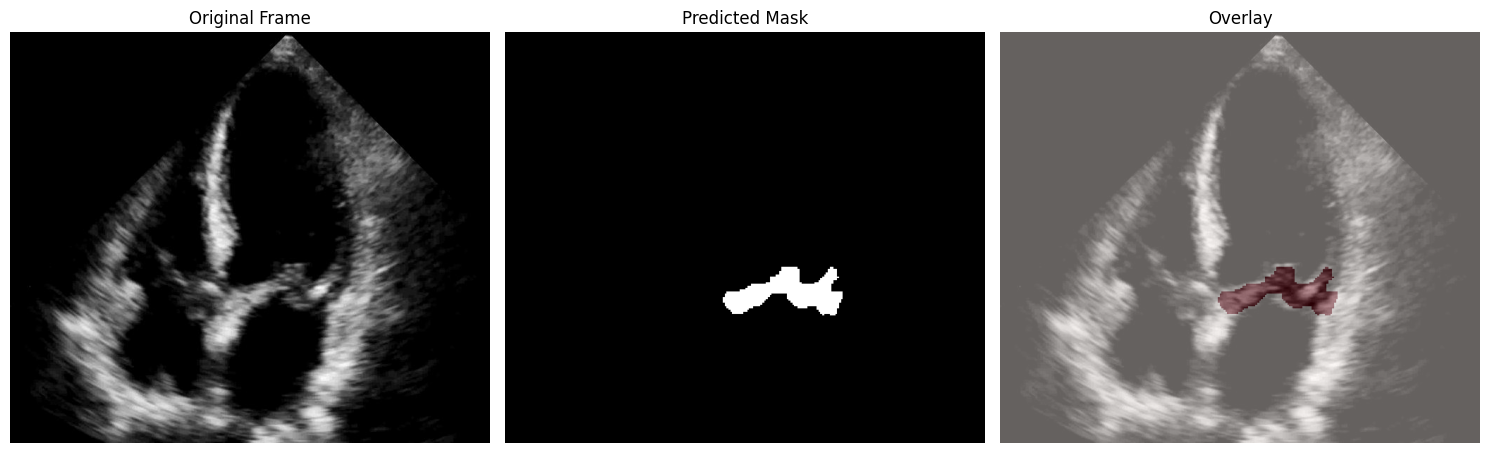

In [ ]:
import matplotlib.pyplot as plt

sample = test_data[10]
video = sample["video"]  # (H, W, T)
t = 2

frame = torch.tensor(video[:, :, t]).float()

frame_padded, meta = resize_and_pad(frame, TARGET_SIZE)
frame_padded = (frame_padded - frame_padded.mean()) / (frame_padded.std() + 1e-6)
frame_padded = frame_padded.cuda()

with torch.no_grad():
    logits = model(frame_padded.unsqueeze(0).unsqueeze(0))
    probs = torch.sigmoid(logits).squeeze()
    binary = (probs > THRESHOLD).float()
    eroded = erode_mask(binary,kernel_size=3,iterations=1)

restored = unpad_and_restore(eroded, meta)
mask = (restored > 0.5).cpu().numpy()

frame_np = frame.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(frame_np, cmap="gray")
axes[0].set_title("Original Frame")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

axes[2].imshow(frame_np, cmap="gray")
axes[2].imshow(mask, cmap="Reds", alpha=0.4)
axes[2].set_title("Overlay")
axes[2].axis("off")

# axes[3].imshow(binary, cmap="gray")
# axes[3].set_title("BInary")
# axes[3].axis("off")

plt.tight_layout()
plt.show()
